In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import signal
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import exponnorm, gamma
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from nilearn.glm.first_level import hemodynamic_models


def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

## Verify equation from paper

In the paper we derive a relationship between condition difference estimates, when using the ConsDurNoRT model, when the signal scales with RT and the RT difference at the group level.  The specific relationship is
$$\hat\beta_1 - \hat\beta_2 = B (\overline{RT}_1 - \overline{RT}_2)$$
where the $\hat\beta_i$ are the ConsDurNoRT parameter estimates for each condition, $\overline{RT}_i$ is the average RT for each condition and $B$ is a common, true activation for each condition.  Importantly, this derivation assumes that $B$ is the true activation for both conditions (so there isn't a condition difference) and that $B$ is the same across subjects.  In the next section we will investigate what happens if $B$ varies across subjects, specifically if $B$ is related to the subject's age and there is interest in studying age relationships at the group level.

Each condition has 10 trials with RTs sampled from Uniform distributions.  I simplified things for this code and just used uniform distributions to sample RTs from, instead of the ExGauss distributions used in the paper (too fussy for a simply demo and won't impact the results).  Note I parameterize the data through a beta_mean (average condition effect, $B$ from above) and beta_diff (average beta difference).  I do it this way to keep the variances the same for both conditions.  Data are simulated with very little between-subject variability simply so the effect of interest can be seen in one simulated data set.  

Each subject's RTs are drawn from U(.5, 1.2) and the random difference is sampled from U(rt_diff - .35, rt_diff + .35), and half this differences is added/subtracted to generate the RT means for each condition.  On average, across subjects, this RT difference will be rt_diff.

The illustrations below will focus on
* Establishing the relationship, $\hat\beta_1 - \hat\beta_2 = B (\overline{RT}_1 - \overline{RT}_2)$, holds for two different values of $B$, even if the response time difference is 0, on average.
* Change the response time average to a nonzero value and show the relationship still holds.


In [2]:
def run1_sub(beta_mean, beta_diff, rt_diff):
    """
    Simulates data under the assumption that the signal scales with RT for 2
    conditions, where beta_mean+.5*beta_diff and beta_mean-.5*beta_diff the true 
    activation magnitudes for each condition.
    Relating to the paper, this corresponds to a true underlying model of RTDur and
    the model used to estimate the condition effects is ConsDurNoRT.  
    The RTs are sampled from a uniform distribution, U(.5, 1.2) for rt_cond2 and 
    U(.5, 1.2) + rt_diff for rt_cond1
    Notably, there does not need to be difference in RT between conditions for the effect to show.
    beta_cond1: True parameter estimate (assuming RTDur is true model) for condition 1
    beta_diff: True difference in conditions
    rt_diff: Difference in RTs between condtion
    output
    beta1_minus_beta2: Estimated condition difference, using ConsDurNoRT model
    rt1_minus_rt2: Difference in average RTs between conditions
    """
    ntrials = 10
    sub_rt = np.random.uniform(.5, 1.2, 1)[0]
    rt_diff_sub = np.random.uniform(rt_diff - .35, rt_diff + .35, 1)[0]
    rt_cond1 = np.random.uniform((sub_rt + rt_diff_sub/2) - .35, 
                                 (sub_rt + rt_diff_sub/2) + .35, 10)
    rt_cond2 = np.random.uniform((sub_rt - rt_diff_sub/2) - .35, 
                                (sub_rt - rt_diff_sub/2) + .35, 10)

    sub_beta_mean = np.random.normal(beta_mean, .1, 1)[0]
    sub_diff = np.random.normal(beta_diff, .1, 1)[0]
    b_cond1 = sub_beta_mean + sub_diff/2
    b_cond2 = sub_beta_mean - sub_diff/2

    onsets_cond1 = np.arange(ntrials)*20
    onsets_cond2 = onsets_cond1 + 10

    tr = 1
    num_trs = np.max(onsets_cond2) + 30
    frame_times = np.arange(num_trs)

    # Generate data signal for each condition
    # Regressor is specified using [onsets, durations, modulations]
    true_signal_scales_w_rt_cond1, _ = hemodynamic_models.compute_regressor(
                        [onsets_cond1, rt_cond1, [1]*ntrials],
                        'spm', frame_times, oversampling=16)
    true_signal_scales_w_rt_cond2, _ = hemodynamic_models.compute_regressor(
                        [onsets_cond2, rt_cond2, [1]*ntrials],
                        'spm', frame_times, oversampling=16)
    bold_scales_w_rt = 1 + b_cond1 * true_signal_scales_w_rt_cond1 +\
         b_cond2 * true_signal_scales_w_rt_cond2 + np.random.normal(scale=.001, size=(num_trs,1))
    # Model regressors
    reg_cons_dur_cond1, _ = hemodynamic_models.compute_regressor(
                        [onsets_cond1, [1]*ntrials, [1]*ntrials],
                        'spm', frame_times, oversampling=16)
    reg_cons_dur_cond2, _ = hemodynamic_models.compute_regressor(
                        [onsets_cond2, [1]*ntrials, [1]*ntrials],
                        'spm', frame_times, oversampling=16)
                        
    model_cons_dur = np.concatenate((reg_cons_dur_cond1, reg_cons_dur_cond2, np.ones((num_trs, 1))), axis=1)
    mod_ols = sm.OLS(bold_scales_w_rt, model_cons_dur).fit() 
    beta1_minus_beta2 = mod_ols.params[0] - mod_ols.params[1]
    rt1_minus_rt2 = np.mean(rt_cond1) - np.mean(rt_cond2)
    output = {'beta1_minus_beta2': beta1_minus_beta2,
        'rt1_minus_rt2': rt1_minus_rt2}
    return output

In [3]:
def run_1group(beta_mean, beta_diff, rt_diff, nsubs):
    """
    Simulate first level parameter estimates for nsubs subjects and run the group
    level model where the condition difference estimate is the dependent variable and
    the RT difference is the independent variable.
    input:
      beta_mean: mean of the betas across the two conditions
      beta_diff: difference in true activation magnitudes (set to 0 to reflect paper derivation)
      rt_diff: Difference in RTs between conditions (set to 0 to reflect paper derivation)
      nsub: number of subjects
    output:
      output: dictionary
          beta_1_minus_beta2_all: constrast estimate across all subjects
          rt1_minus_rt2_all: rt differences across all subjects  
          group_slope: group model slope (beta1_minus_beta2_all is DV, rt1_minus_rt2_all is IV)
          group_intercept: group model intercept
    """
    beta1_minus_beta2_all = []
    rt1_minus_rt2_all = []
    for sub in range(nsubs):
        sub_loop = run1_sub(beta_mean, beta_diff, rt_diff)
        beta1_minus_beta2_all.append(sub_loop['beta1_minus_beta2'])
        rt1_minus_rt2_all.append(sub_loop['rt1_minus_rt2'])

    desmat_group = np.concatenate(
      (np.atleast_2d(np.array(rt1_minus_rt2_all)).transpose(), np.ones((nsubs, 1))), axis=1)
    mod_group = sm.OLS(beta1_minus_beta2_all, desmat_group).fit() 
    output = {'beta1_minus_beta2_all': beta1_minus_beta2_all,
        'rt1_minus_rt2_all': rt1_minus_rt2_all,
        'group_slope': mod_group.params[0],
        'group_intercept': mod_group.params[1]}
    return output

### Show the relationship holds when the response time average is 0 for two different values of $B$

B is the product of the common true activation for both conditions and 1/duration used in the ConsDurNoRT regressors (in this case 1).  So B is the common true activation for both conditions, or beta_mean in the code.  Note, rt_diff is 0.  A goal of this simulation is to make it very clear that one not immune from these group level RT confounds if the average RT difference is 0 across subjects.

True activation magnitudes are 1.0 and 1.0 for conditions 1 and 2, respectively.
The common true betas match the group slope between the condition difference and rt difference, which is 1.001


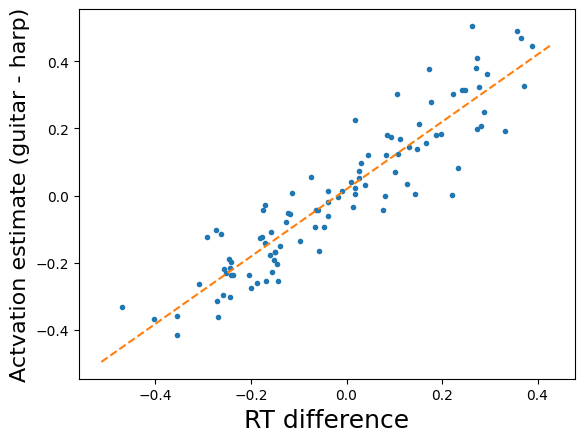

In [4]:
beta_mean = 1
beta_diff = 0
rt_diff = 0
nsubs = 100
output_beta_1_rt_diff_0 = run_1group(beta_mean, beta_diff, rt_diff, nsubs)

print(f'True activation magnitudes are {beta_mean + .5*beta_diff} and '
    f'{beta_mean + .5*beta_diff} for conditions 1 and 2, respectively.')
print(f'The common true betas match the group slope between the condition '
    f'difference and rt difference, which is {np.round(output_beta_1_rt_diff_0["group_slope"], 3)}')


plt.plot(output_beta_1_rt_diff_0['rt1_minus_rt2_all'], 
    output_beta_1_rt_diff_0['beta1_minus_beta2_all'], '.')
plt.xlabel('RT difference', fontsize=18)
plt.ylabel('Actvation estimate (guitar - harp)', fontsize=16)
#plt.ylabel('ConsDurNoRT condition difference estimate \n (note: true signal scales with RT)', fontsize=18)

abline(output_beta_1_rt_diff_0['group_slope'], output_beta_1_rt_diff_0['group_intercept'])
plt.savefig(f'effect_vs_rtdiff_betamean_{beta_mean}_rtdiff_{rt_diff}.png')
plt.show()


Repeat, but change the true, shared beta value.

True activation magnitudes are 5.0 and 5.0 for conditions 1 and 2, respectively.
The common true betas match the group slope between the condition difference and rt difference, which is 4.973


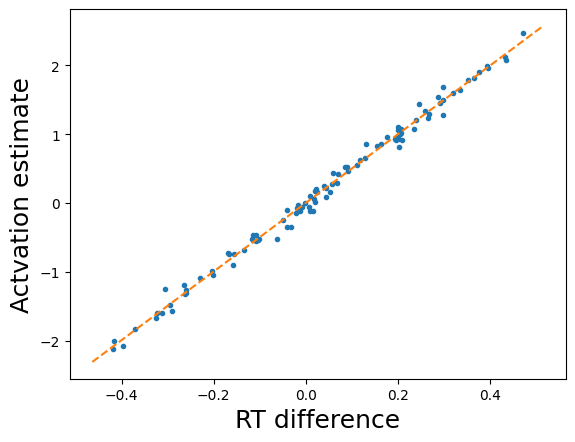

In [26]:
beta_mean = 5
beta_diff = 0
rt_diff = 0
nsubs = 100
output_beta_5_rt_diff_0 = run_1group(beta_mean, beta_diff, rt_diff, nsubs)

print(f'True activation magnitudes are {beta_mean + .5*beta_diff} and '
    f'{beta_mean + .5*beta_diff} for conditions 1 and 2, respectively.')
print(f'The common true betas match the group slope between the condition '
     f'difference and rt difference, which is {np.round(output_beta_5_rt_diff_0["group_slope"], 3)}')


plt.plot(output_beta_5_rt_diff_0['rt1_minus_rt2_all'], 
    output_beta_5_rt_diff_0['beta1_minus_beta2_all'], '.')
plt.xlabel('RT difference', fontsize=18)
plt.ylabel('Actvation estimate', fontsize=18)

#plt.ylabel('ConsDurNoRT condition difference estimate \n (note: true signal scales with RT)', fontsize=18)
abline(output_beta_5_rt_diff_0['group_slope'], output_beta_5_rt_diff_0['group_intercept'])
plt.savefig(f'effect_vs_rtdiff_betamean_{beta_mean}_rtdiff_{rt_diff}.png')

plt.show()

###  There is no impact if the average RT difference is nonzero
This is actually just a simple property of regression coefficients.  Adding or subtracting a value to a regressor won't change that regressor's parameter estimate (just the intercept).  

True activation magnitudes are 1.0 and 1.0 for conditions 1 and 2, respectively.
The common true betas match the group slope between the condition difference and rt difference, which is 1.038


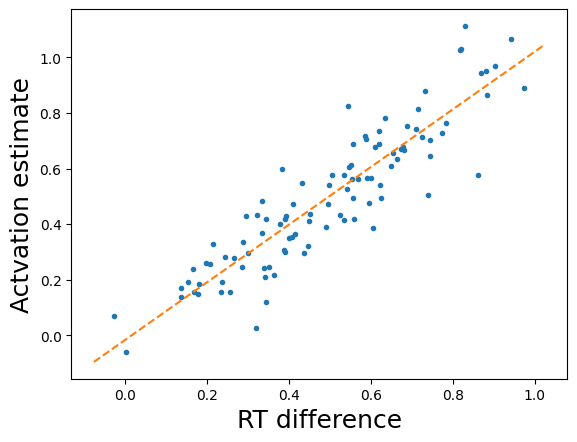

In [28]:
beta_mean = 1
beta_diff = 0
rt_diff = 0.5
nsubs = 100
output_beta_1_rt_diff_0_5 = run_1group(beta_mean, beta_diff, rt_diff, nsubs)

print(f'True activation magnitudes are {beta_mean + .5*beta_diff} and '
      f'{beta_mean + .5*beta_diff} for conditions 1 and 2, respectively.')
print(f'The common true betas match the group slope between the condition '
     f'difference and rt difference, which is {np.round(output_beta_1_rt_diff_0_5["group_slope"], 3)}')


plt.plot(output_beta_1_rt_diff_0_5['rt1_minus_rt2_all'], 
    output_beta_1_rt_diff_0_5['beta1_minus_beta2_all'], '.')
plt.xlabel('RT difference', fontsize=18)
plt.ylabel('Actvation estimate', fontsize=18)

#plt.ylabel('ConsDurNoRT condition difference estimate \n (note: true signal scales with RT)')
abline(output_beta_1_rt_diff_0_5['group_slope'], output_beta_1_rt_diff_0_5['group_intercept'])

plt.savefig(f'effect_vs_rtdiff_betamean_{beta_mean}_rtdiff_{rt_diff}.png')

plt.show()

## Can we simply add RT to the group level model if it was omitted from the time series level model? Not really

Recall the two key assumptions in that derivation above about the parameter, $B$.  The first is that the activation for each condition is the same ($B$) within-session and the second is that this activation magnitude is also the same across subjects.  What happens when B varies across subjects (but not conditions) and is related to some variable of interest?  For this example we'll assume age is our variable of interest.

So the question is, if there isn't a condition difference ($B$ is the same for both conditions), but this value of $B$ varies across subjects such that $B=\gamma_0 + \gamma_1 age + \epsilon$, if the signal scales with RT, but we use the ConsDurNoRT model, can we fix any problems caused by the RT omission at the group level?  Spoiler: no and adding RT might actually make things worse!

First, we can appreciate that this problem gets complicated very quickly.  I will remind you that B is the same for conditions, and so the true condition difference is not actually realted to age in any way, but we will see that the estimated condition difference, when using ConsDurNoRT, pulls in an age effect!  Here's the equation from the paper, where $\hat\beta_1$ is the condition 1 effect estimate from the ConsDurNoRT model, when the signal scales with RT ($\hat\beta_2$ is the same for condition 2), B is the common activation ($B=\gamma_0 + \gamma_1 age$) and $\overline{RT}_1$ is the average RT for condition 1 (similarly for condition 2)
$$\hat\beta_1 - \hat\beta_2 = B (\overline{RT}_1 - \overline{RT}_2)$$
If we plug in the expression for $B$, assign $\Delta RT = \overline{RT}_1 - \overline{RT}_2$ and expand we get
$$\hat\beta_1 - \hat\beta_2 = (\gamma_0 + \gamma_1 age) (\Delta RT)$$
$$\hat\beta_1 - \hat\beta_2 = \gamma_0 \Delta RT+ \gamma_1 age\Delta RT.$$
So this problem escalated quickly!  First, we have a main $\Delta RT$ effect as we did before, but now we have an interaction of $age\times\Delta RT$ as well!  So now age has made its way into the group model, compounding our problem!  Not only has our poor level 1 model introduced a false RT effect into the group model, we now have a false age effect as well!

The following simulations will illustrate these points.  Note this is just one way a group covariate of interest could be involved.  It could also be related to $\Delta RT$, which would have different reprecussions.  It could also be directly related to $\beta_1 - \beta_2$, the true condition difference effect, which would play out in a different, even more complicated way.  The goal of this simulation is to discourage from adding RT as a confound to the group level model, since it is not likely to help at all and, as we will see, it may inflate the problem.


In [7]:
# Similar to the function above, except now B (sub_beta_mean) will be a 
# function of age.  I also add the estimation of ConsDurRT.

def run1_sub_common_beta_related_age(age_mean, age_sd, gam0, gam1, rt_diff):
    """
    Make data for one subject that scale with RT and run the ConsDurNoRT and 
      ConsDurRT models to estimate the condition difference.  The true condition
      activations are equal and are related to age. Specifically, the common 
      true average activaton is B=gam0 + gam1 age + noise a condition difference 
      (0 on average) is added/subtracted to create condition effects.  Note the 
      true condition difference is not related to age. As above, the signal scales with RT.
    input:
      age_mean: average age
      age_sd: standard deviation of age
      gam0: intercept for age/B relationship
      gam1: age slope for age/B relationship
      rt_diff: response time difference
    output: 
      dictionary containing
      beta1_minus_beta2_consdur_no_rt: contrast estimate from the ConsDurNoRT model
      beta1_minus_beta2_consdur_yes_rt: contrast estimate from the ConsDurRT model
      rt1_minus_rt2: difference in average response times for each condition
      age: age
    """
    ntrials = 10
    
    age = np.random.normal(age_mean, age_sd, 1)

    sub_rt = np.random.uniform(.5, 1.2, 1)[0]
    rt_diff_sub = np.random.uniform(rt_diff - .35, rt_diff + .35, 1)[0]
    rt_cond1 = np.random.uniform((sub_rt + rt_diff_sub/2) - .35, 
        (sub_rt + rt_diff_sub/2) + .35, 10)
    rt_cond2 = np.random.uniform((sub_rt - rt_diff_sub/2) - .35, 
        (sub_rt - rt_diff_sub/2) + .35, 10)

    # The only place age enters in.  Note that the true condition difference will *not*
    # involve age at all (subtract b_cond1 - b_cond2 to convince yourself)
    sub_beta_mean = gam0 + gam1*age + np.random.normal(0, .1, 1)[0]
    sub_diff = np.random.normal(0, .1, 1)[0]
    b_cond1 = sub_beta_mean + sub_diff/2
    b_cond2 = sub_beta_mean - sub_diff/2
 
    onsets_cond1 = np.arange(ntrials)*20
    onsets_cond2 = onsets_cond1 + 10

    tr = 1
    num_trs = np.max(onsets_cond2) + 30
    frame_times = np.arange(num_trs)

    # Generate data signal for each condition
    # Regressor is specified using [onsets, durations, modulations]
    true_signal_scales_w_rt_cond1, _ = hemodynamic_models.compute_regressor(
                        [onsets_cond1, rt_cond1, [1]*ntrials],
                        'spm', frame_times, oversampling=16)
    true_signal_scales_w_rt_cond2, _ = hemodynamic_models.compute_regressor(
                        [onsets_cond2, rt_cond2, [1]*ntrials],
                        'spm', frame_times, oversampling=16)
    bold_scales_w_rt = 1 + b_cond1 * true_signal_scales_w_rt_cond1 + \
        b_cond2 * true_signal_scales_w_rt_cond2 + \
        np.random.normal(scale=.001, size=(num_trs,1))
    # Model regressors
    reg_cons_dur_cond1, _ = hemodynamic_models.compute_regressor(
                        [onsets_cond1, [1]*ntrials, [1]*ntrials],
                        'spm', frame_times, oversampling=16)
    reg_cons_dur_cond2, _ = hemodynamic_models.compute_regressor(
                        [onsets_cond2, [1]*ntrials, [1]*ntrials],
                        'spm', frame_times, oversampling=16)
    # adding an rt-modulate regressor so I can also run ConsDurRT. 
    trial_type = np.array([1, 2] * ntrials)
    onsets_all = 0 * trial_type
    onsets_all[trial_type == 1] = onsets_cond1
    onsets_all[trial_type == 2] = onsets_cond2
    rt_all = 0 * 1/trial_type
    rt_all[trial_type == 1] = rt_cond1
    rt_all[trial_type == 2] = rt_cond2
    reg_rt_mod, _ =  hemodynamic_models.compute_regressor([onsets_all, [1]*ntrials*2, rt_all],
                        'spm', frame_times, oversampling=16)                 
    desmat_cons_dur = np.concatenate((reg_cons_dur_cond1, reg_cons_dur_cond2, 
        np.ones((num_trs, 1))), axis=1)
    mod_cons_dur_no_rt = sm.OLS(bold_scales_w_rt, desmat_cons_dur).fit() 
    beta1_minus_beta2_cons_dur_no_rt = mod_cons_dur_no_rt.params[0] - mod_cons_dur_no_rt.params[1]
    #rt1_minus_rt2 = np.mean(rt_cond1) - np.mean(rt_cond2)
    rt1_minus_rt2 = rt_diff_sub

    desmat_cons_dur_rt = np.concatenate((reg_cons_dur_cond1, reg_cons_dur_cond2, 
        reg_rt_mod, np.ones((num_trs, 1))), axis=1)
    mod_cons_dur_yes_rt = sm.OLS(bold_scales_w_rt, desmat_cons_dur_rt).fit() 
    beta1_minus_beta2_cons_dur_yes_rt = mod_cons_dur_yes_rt.params[0] - mod_cons_dur_yes_rt.params[1]
    output = {'beta1_minus_beta2_consdur_no_rt': beta1_minus_beta2_cons_dur_no_rt,
        'beta1_minus_beta2_consdur_yes_rt': beta1_minus_beta2_cons_dur_yes_rt,
        'rt1_minus_rt2': rt1_minus_rt2,
        'age': age}
    return output

In [8]:
def get_within_sub_estimates(age_mean, age_sd, gam0, gam1, rt_diff, nsubs):
    """
    Simulate first level parameter estimates for nsubs subjects and run the group
    level model where the condition difference estimate is the dependent variable and
    the RT difference is the independent variable.
    input:
      age_mean/age_sd: mean/sd age used to build B=gam0+gam1 age relationship
      gam0/gam1: intercept and slope relating age to the common activation for both conditions, B
      rt_diff: Average rt difference
      nsubs: Number of subjects
    output:
      output: dictionary
          beta1_minus_beta2_consdur_no_rt_all: constrast estimate across all subjects from ConsDurNoRT model
          beta1_minus_beta2_consdur_yes_rt_all: constrast estimate across all subjects from ConsDurRT model
          rt1_minus_rt2_all: rt differences across all subjects  
          age_all: ages across all subjects
    """
    beta1_minus_beta2_consdur_no_rt_all = []
    beta1_minus_beta2_consdur_yes_rt_all = []
    rt1_minus_rt2_all = []
    age_all = []
    for sub in range(nsubs):
        sub_loop = run1_sub_common_beta_related_age(age_mean, age_sd, gam0, gam1, rt_diff)
        beta1_minus_beta2_consdur_no_rt_all.append(sub_loop['beta1_minus_beta2_consdur_no_rt'])
        beta1_minus_beta2_consdur_yes_rt_all.append(sub_loop['beta1_minus_beta2_consdur_yes_rt'])
        rt1_minus_rt2_all.append(sub_loop['rt1_minus_rt2'])
        age_all.append(sub_loop['age'])
        
    output = {'beta1_minus_beta2_consdur_no_rt_all': beta1_minus_beta2_consdur_no_rt_all,
    'beta1_minus_beta2_consdur_yes_rt_all': beta1_minus_beta2_consdur_yes_rt_all,
        'rt1_minus_rt2_all': rt1_minus_rt2_all,
        'age_all': age_all}
    return output

Recall the relationship from above, expressing the ConsDurRT condition difference estimates (when signal scales with RT):
$$\hat\beta_1 - \hat\beta_2 = \gamma_0 \Delta RT+ \gamma_1 age\Delta RT.$$
* First show the true relationship and verify the above equation holds.  
* Next look at the model that only contains age.  In this case, since $\Delta RT$ is omitted, the coefficient for age is approximately $\gamma_1 mean(\Delta RT) \approx \gamma_1 \times rt\_diff.$
* Does the ConsDurRT model's condition difference have a significant linear relationship with age? (No)
* What happens if we adjust the ConsDurNoRT model's age estimate for $\Delta RT$? (gets worse)

In [9]:
age_mean = 50
age_sd = 10
gam0 = 1
gam1 = 2
rt_diff = 0.4
nsubs = 100

In [10]:
sim_out = get_within_sub_estimates(age_mean, age_sd, gam0, gam1, rt_diff, nsubs)

### Result 1: Verify $\hat\beta_1 - \hat\beta_2 = \gamma_0 \Delta RT+ \gamma_1 age\Delta RT$ relationship holds. 

In [11]:
rt_diff_all = np.atleast_2d(np.array(sim_out['rt1_minus_rt2_all'])).transpose()
age = np.array(sim_out['age_all'])

print(f'Expected delta_rt coefficient to be gamma0 ({gam0}) and age x delta_rt' 
    f'coefficient to be gamma1 ({gam1})')

data_for_models = pd.DataFrame.from_dict({'delta_rt': list(rt_diff_all[:,0]), 
    'age_x_delta_rt': list(age[:,0]*rt_diff_all[:,0]), 'age': list(age[:,0]),
    'beta_diff_cons_dur_no_rt': list(sim_out['beta1_minus_beta2_consdur_no_rt_all']),
    'beta_diff_cons_dur_yes_rt': list(sim_out['beta1_minus_beta2_consdur_yes_rt_all'])})
mod_verify = smf.ols(formula='beta_diff_cons_dur_no_rt ~ delta_rt + age_x_delta_rt', data=data_for_models).fit()
mod_verify.summary(slim=True)


Expected delta_rt coefficient to be gamma0 (1) and age x delta_rtcoefficient to be gamma1 (2)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     beta_diff_cons_dur_no_rt   R-squared:                       0.819
Model:                                  OLS   Adj. R-squared:                  0.815
No. Observations:                       100   F-statistic:                     219.6
Covariance Type:                  nonrobust   Prob (F-statistic):           9.63e-37
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1488      2.122      0.070      0.944      -4.062       4.360
delta_rt         -10.7920     13.283     -0.812      0.419     -37.155      15.571
age_x_delta_rt     2.2404      0.255      8.787      0.000       1.734       2.746
==================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

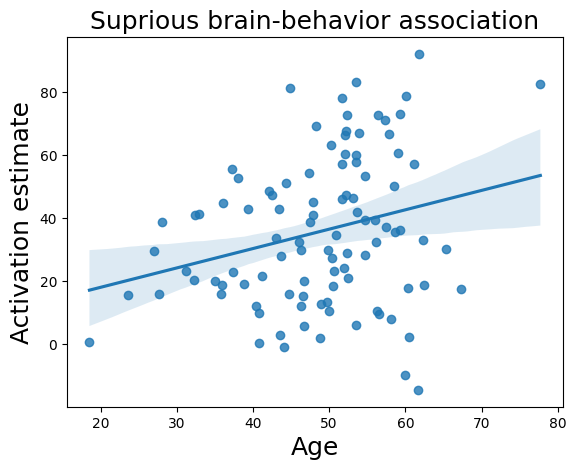

In [38]:
sns.regplot(x="age", y="beta_diff_cons_dur_no_rt", data=data_for_models)
plt.xlabel('Age', fontsize=18)
plt.ylabel('Activation estimate', fontsize=18)
plt.title('Suprious brain-behavior association', fontsize=18)
plt.savefig('suprious_BBA_nort.png')

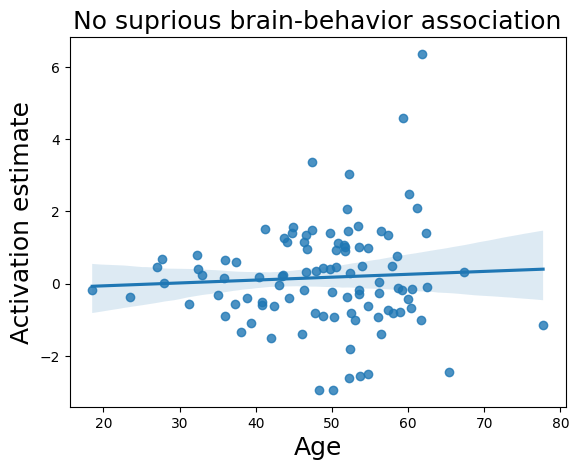

In [40]:
sns.regplot(x="age", y="beta_diff_cons_dur_yes_rt", data=data_for_models)
plt.xlabel('Age', fontsize=18)
plt.ylabel('Activation estimate', fontsize=18)
plt.title('No suprious brain-behavior association', fontsize=18)
plt.savefig('suprious_BBA_rt.png')

### Result 2: There is a false relationship of the condition difference (from ConsDurNoRT) with age.  Expected parameter is $\gamma_1 mean(\Delta RT) \approx \gamma_1 \times rt\_diff.$

In [12]:
print(f'Expected age coefficient to be gamma1 x rt_diff = ({gam1}) x  ({rt_diff}) = {gam1*rt_diff}')
print(f'REMINDER: There is no TRUE relationship between condition difference and age, so this is artifact!')
mod_cons_dur_no_rt_age_effect = smf.ols(formula="beta_diff_cons_dur_no_rt ~ age", data=data_for_models).fit()
mod_cons_dur_no_rt_age_effect.summary(slim=True)

Expected age coefficient to be gamma1 x rt_diff = (2) x  (0.4) = 0.8
REMINDER: There is no TRUE relationship between condition difference and age, so this is artifact!


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     beta_diff_cons_dur_no_rt   R-squared:                       0.069
Model:                                  OLS   Adj. R-squared:                  0.060
No. Observations:                       100   F-statistic:                     7.281
Covariance Type:                  nonrobust   Prob (F-statistic):            0.00821
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.7287     11.365      0.504      0.615     -16.825      28.282
age            0.6150      0.228      2.698      0.008       0.163       1.067
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Result 3: Show there is not a significant age effect if ConsDurRT was used in the level 1 analysis

In [13]:
mod_cons_dur_yes_rt_age_effect = smf.ols(formula="beta_diff_cons_dur_yes_rt ~ age", 
    data=data_for_models).fit()
mod_cons_dur_yes_rt_age_effect.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     beta_diff_cons_dur_yes_rt   R-squared:                       0.003
Model:                                   OLS   Adj. R-squared:                 -0.007
No. Observations:                        100   F-statistic:                    0.3158
Covariance Type:                   nonrobust   Prob (F-statistic):              0.575
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2175      0.709     -0.307      0.760      -1.625       1.190
age            0.0080      0.014      0.562      0.575      -0.020       0.036
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Result 4: What happens if we add the RT difference to try to adjust the age effect when using the ConsDurNoRT condition difference. (Buckle up, this is bad)

Note, I do not have hypothesized parameter estimates for this one, but the age effect gets a *smaller* p-value, which is not great.  Recall, there is not an actual age effect so this is a false finding.

In [14]:
mod_cons_dur_no_rt_age_effect_w_rtdiff = smf.ols(formula="beta_diff_cons_dur_no_rt ~ age + delta_rt", 
    data=data_for_models).fit()
mod_cons_dur_no_rt_age_effect_w_rtdiff.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     beta_diff_cons_dur_no_rt   R-squared:                       0.788
Model:                                  OLS   Adj. R-squared:                  0.783
No. Observations:                       100   F-statistic:                     179.8
Covariance Type:                  nonrobust   Prob (F-statistic):           2.37e-33
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -39.3317      5.998     -6.557      0.000     -51.236     -27.427
age            0.7870      0.110      7.163      0.000       0.569       1.005
delta_rt     100.4215      5.545     18.110      0.000      89.416     111.427
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### New code to look at consistency over many simulated data sets

Eventually I will need to rewrite the original functions above to allow for more flexibility (input variance parameters, etc) so I can allow for more perturbations to test things out

In [15]:
def estimate_many_group_conf_ints(age_mean, age_sd, gam0, gam1, rt_diff, nsubs, nsims):
    """
    
    """
    parameter_est = []
    half_ci_width = []
    model_name = []
    covariate_name = []
    hypothesized_value = []
    sim_number = []
    ci_capture = []

    model_covariate_map = {
        'mod_verify': {
            'formula': 'beta_diff_cons_dur_no_rt ~ delta_rt + age_x_delta_rt', 
            'variables': ['delta_rt', 'age_x_delta_rt'],
            'hypothesized_value': [gam0, gam1]
        },
        'mod_cons_dur_no_rt_age_effect': {
            'formula': 'beta_diff_cons_dur_no_rt ~ age',
            'variables': ['age'],
            'hypothesized_value': [gam1*rt_diff]
        },
        'mod_cons_dur_yes_rt_age_effect': {
            'formula': 'beta_diff_cons_dur_yes_rt ~ age',
            'variables': ['age'],
            'hypothesized_value': [0]
        },
        'mod_cons_dur_no_rt_age_effect_w_rtdiff': {
            'formula': 'beta_diff_cons_dur_no_rt ~ age + delta_rt',
            'variables': ['age', 'delta_rt'],
            'hypothesized_value': [gam1*rt_diff, gam0]
        }
    }

    for sim in range(nsims):
        sim_out = get_within_sub_estimates(age_mean, age_sd, gam0, gam1, rt_diff, nsubs)
        rt_diff_all = np.atleast_2d(np.array(sim_out['rt1_minus_rt2_all'])).transpose()
        age = np.array(sim_out['age_all'])
        data_for_models = pd.DataFrame.from_dict({'delta_rt': list(rt_diff_all[:,0]), 
        'age_x_delta_rt': list(age[:,0]*rt_diff_all[:,0]), 'age': list(age[:,0]),
        'beta_diff_cons_dur_no_rt': list(sim_out['beta1_minus_beta2_consdur_no_rt_all']),
        'beta_diff_cons_dur_yes_rt': list(sim_out['beta1_minus_beta2_consdur_yes_rt_all'])})
        for model, model_info in model_covariate_map.items():
            model_loop = smf.ols(model_info['formula'], data=data_for_models).fit()
            for count, variable in enumerate(model_info['variables']):
                ci_loop = model_loop.conf_int().loc[[variable]]
                hypothesized_value_loop =  model_info['hypothesized_value'][count]
                ci_capture.append(1*((ci_loop[0][0] <= hypothesized_value_loop) and (hypothesized_value_loop <= ci_loop[1][0])))
                model_name.append(model_info['formula'])
                covariate_name.append(variable)
                hypothesized_value.append(model_info['hypothesized_value'][count])
                parameter_est.append(model_loop.params.loc[variable])
                half_ci_width.append(np.diff(model_loop.conf_int().loc[[variable]])[0][0]/2)
                sim_number.append(sim)
    
    output = pd.DataFrame({
        'model_name': model_name,
        'covariate_name': covariate_name,
        'Parameter estimate': parameter_est,
        'half_ci_width': half_ci_width,
        'hypothesized_value': hypothesized_value,
        'sim_number': sim_number,
        'ci_capture': ci_capture
    })
    return output



In [16]:
age_mean = 50
age_sd = 10
gam0 = 1
gam1 = 2
rt_diff = 0.2
nsubs = 50
nsims = 100

many_sim_out = estimate_many_group_conf_ints(age_mean, age_sd, gam0, gam1, rt_diff, nsubs, nsims)

In [17]:
many_sim_out['model_and_covariate'] = many_sim_out['model_name'] + '\n' + many_sim_out['covariate_name']
df2 = many_sim_out.sort_values(by=['model_and_covariate', 'Parameter estimate'])
nrows = df2.shape[0]
df2['newnum'] = np.tile(np.arange(nsims), int(nrows/nsims))

In [18]:
many_sim_out.groupby('model_and_covariate')['ci_capture'].mean()

model_and_covariate
beta_diff_cons_dur_no_rt ~ age\nage                                     0.95
beta_diff_cons_dur_no_rt ~ age + delta_rt\nage                          0.91
beta_diff_cons_dur_no_rt ~ age + delta_rt\ndelta_rt                     0.00
beta_diff_cons_dur_no_rt ~ delta_rt + age_x_delta_rt\nage_x_delta_rt    0.98
beta_diff_cons_dur_no_rt ~ delta_rt + age_x_delta_rt\ndelta_rt          0.97
beta_diff_cons_dur_yes_rt ~ age\nage                                    0.95
Name: ci_capture, dtype: float64

In [19]:
g = sns.FacetGrid(df2, row="model_and_covariate", sharey=False, size=10)
g.map(plt.plot, 'newnum','hypothesized_value', color='orange' )
g.map(plt.errorbar, "newnum", "Parameter estimate", "half_ci_width", linestyle="none", marker="o")
g.set_titles('{row_name}')

TypeError: __init__() got an unexpected keyword argument 'size'